In [1]:
import pandas as pd
import mdtraj as md
#import afrc
import numpy as np
from numpy.random import seed
from numpy.random import shuffle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from __future__ import print_function
import seaborn as sns
from matplotlib.ticker import NullFormatter, MaxNLocator
from pandas.plotting import scatter_matrix
import matplotlib.ticker as ticker
#import plotly.graph_objects as go
import scipy as sp
from itertools import chain, combinations
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import spatial
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
import scipy.stats as stats
#import statsmodels.stats.weightstats
from matplotlib import path
import matplotlib
from scipy.stats import probplot,shapiro, sem
#import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score, mean_squared_error
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.linear_model import RidgeCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler

from matplotlib import cm
from numpy import linspace
#import umap.umap_ as umap
#import pylab
import os
#import PIL
from scipy.ndimage import gaussian_filter, uniform_filter1d

# Some Functions

In [2]:
def RSA_based_fC(protein_var,protein_name,poly_id,
                       GW_moment_var,every_ith_snap,GW_every_ith_snap,radius_):
    x_total=[]
    y_total=[]
    if poly_id=='protein':
        protein_label=protein_name
        temp_protein=protein_var.copy()
        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)
        x_total=list(chain.from_iterable(x_total))
        y_total=list(chain.from_iterable(y_total))
        poly_var=protein_var.copy()
        protein_pro=poly_var[['ratio','RSA']].iloc[:every_ith_snap,:].copy()
        protein_pro['polymer_id']=np.repeat(protein_label,protein_pro.shape[0])
        del x_total, y_total, temp_protein

    elif poly_id=='polymer':
        print('protein_var MUST be single epas')
        protein_label=protein_name
        temp_protein=protein_var.copy()
        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)
        x_total=list(chain.from_iterable(x_total))
        y_total=list(chain.from_iterable(y_total))
        poly_var=protein_var.copy()
        protein_pro=poly_var[['ratio','RSA']].iloc[:every_ith_snap,:].copy()
        protein_pro['polymer_id']=np.repeat(protein_label,protein_pro.shape[0])
        del x_total, y_total, temp_protein
    
    
    elif poly_id=='pei':
        print('protein_var MUST be single proton state')
        protein_label='pei_'+ str(protein_name)
        temp_protein=protein_var.copy() # temp_protein isn't really needed but just adding
        poly_var=protein_var.copy()
        protein_pro=poly_var[['ratio','RSA']].iloc[:every_ith_snap,:].copy()
        protein_pro['polymer_id']=np.repeat(protein_label,protein_pro.shape[0])
        del x_total, y_total, temp_protein
    else:
        return print('ERROR')
    
    
    GW_po=GW_moment_var[['ratio','RSA']][::GW_every_ith_snap].copy()
    GW_po['polymer_id']=np.repeat('GW',GW_po.shape[0])
    
    #calculate mean and stdev values (must keep same mean and stdev values)
    upto_snapshots=1000000
    GW_mean_ratio=np.mean(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_std_ratio=np.std(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_mean_RSA=np.mean(GW_po['RSA'].values[0:(upto_snapshots+1)])
    GW_std_RSA=np.std(GW_po['RSA'].values[0:(upto_snapshots+1)])
        
    combined_pro_po=pd.concat([GW_po,protein_pro],axis=0,ignore_index=True)
    combined_pro_po['stdd_ratio']=(combined_pro_po['ratio'].values-GW_mean_ratio)/(GW_std_ratio)
    combined_pro_po['stdd_RSA']=(combined_pro_po['RSA'].values-GW_mean_RSA)/(GW_std_RSA)
    po_x=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_RSA'].values
    po_y=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_ratio'].values
    pro_x=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_RSA'].values
    pro_y=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_ratio'].values
    
    GW_points=np.c_[po_x, po_y]
    protein_points=np.c_[pro_x, pro_y]    
    tree_GW=spatial.cKDTree(GW_points)
    tree_protein=spatial.cKDTree(protein_points)

    GW_not_in_range=[]
    j=0
    for point in GW_points:

        if not tree_protein.query_ball_point(point,radius_):
            GW_not_in_range.append(point)
        j+=1
        if j%500000==0:
            print(f'{j} GW snapshots completed')
                
    fC_by_distance=(GW_points.shape[0]-len(GW_not_in_range))/(GW_points.shape[0])
    return fC_by_distance    


In [3]:
def RSA_Rs_protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= 'RSA'
    y_variable=r'$R_s$'
    global fC_value, grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]


    x_polmodel_GW.append(testeq_GW['RSA'].values)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)

        fC_value=RSA_based_fC(temp_protein,
                       protein_label,
                       second_obj,testeq_GW,
                       temp_protein.shape[0],
                       1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=1
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['RSA'].max()>max_x_val or testeq_GW['RSA'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    axTemperature.text(0.7,0.8,
                       r'$f_{C\_shape}$ = '+format(fC_value,'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)
    #axTemperature.text(0.7,0.74,
    #                   '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
    #                  transform=axTemperature.transAxes,fontsize=8)    
    axTemperature.text(0.7,0.74,
                       '$\\nu$ = '+format(idrome_prop_flucs[idrome_prop_flucs.seq_name==protein_label].nu.values[0],'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    
    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 

def mod_RSA_Rs_protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= 'RSA'
    y_variable=r'$R_s$'
    global fC_value, grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]


    x_polmodel_GW.append(testeq_GW['RSA'].values)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)

        fC_value=RSA_based_fC(temp_protein,
                       protein_label,
                       second_obj,testeq_GW,
                       temp_protein.shape[0],
                       1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=1
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['RSA'].max()>max_x_val or testeq_GW['RSA'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(3.2,3))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    axTemperature.text(1.03,1.12,
                       r'$f_{C\_shape}$ = '+format(fC_value,'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)
    #axTemperature.text(0.7,0.74,
    #                   '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
    #                  transform=axTemperature.transAxes,fontsize=8)    
    axTemperature.text(1.03,1.05,
                       '$\\nu$ = '+format(idrome_prop_flucs[idrome_prop_flucs.seq_name==protein_label].nu.values[0],'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    
    axTemp_legend=axTemperature.legend(fontsize=7,loc=(1.01,1.19),borderpad = 0.03,
                                       labelspacing = 0.05, handlelength  = 1,frameon=False,
                                       handletextpad = 0.005)

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Dens.',fontsize=11)
    axHisty.set_xlabel('Prob. Dens.',fontsize=11)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



In [4]:
def protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= r'$R_g\left/R_g^{theta}\right.$' 
    y_variable=r'$R_s$'
    global grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]

    GW_rg = testeq_GW['Rg2']**0.5
    GW_rg_mean = GW_rg.mean()
    GW_rg_by_rg_mean = GW_rg/GW_rg_mean
    testeq_GW['Rg/Rg_mean'] = GW_rg_by_rg_mean
    
    x_polmodel_GW.append(GW_rg_by_rg_mean)
    y_polmodel_GW.append(testeq_GW['ratio'].values)
    
    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein['Rg/Rg_theta'].values)
        y_total.append(temp_protein.ratio.values)

        # fC_value=RSA_based_fC(temp_protein,
        #                protein_label,
        #                second_obj,testeq_GW,
        #                temp_protein.shape[0],
        #                1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=3
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['Rg/Rg_mean'].max()>max_x_val or testeq_GW['Rg/Rg_mean'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    # axTemperature.text(0.7,0.8,
    #                    '$f_C$= '+format(fC_value,'0.3f'),
    #                   transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



In [5]:
def RSA_Rs_SAW_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= 'RSA'
    y_variable=r'$R_s$'
    global fC_value, grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]


    x_polmodel_GW.append(testeq_GW['RSA'].values)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    if second_obj=='polymer':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)

        fC_value=RSA_based_fC(temp_protein,
                       protein_label,
                       second_obj,testeq_GW,
                       temp_protein.shape[0],
                       1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=1
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['RSA'].max()>max_x_val or testeq_GW['RSA'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 200
    nybins = 100
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    axTemperature.text(0.7,0.8,
                       '$f_C$= '+format(fC_value,'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



# generate a dataframe connecting directory with seq_name in their property df

In [6]:
seq_name_AFRC = pd.read_csv('../holehouse_project/IDRome_shape_mean_size_mean_added.csv')

In [7]:
%%time
seq_name_list = []
seq_name_dir = []
protein_name = []
for root, dirs, files in os.walk('IDROME_larsen/IDRome_v4/', topdown=False):
    for name in files:
        seq_name_list.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]+['_']+[root.split('/')[len(root.split('/'))-1]]))
        protein_name.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]))
        seq_name_dir.append(root)
        break
seq_name_dir_df = pd.DataFrame(zip(seq_name_list,seq_name_dir,protein_name),columns=['seq_name','seq_dir','protein_uniprot_id'])
del seq_name_list, seq_name_dir, protein_name
seq_name_dir_df

CPU times: user 291 ms, sys: 1.64 s, total: 1.93 s
Wall time: 15.9 s


,seq_name,seq_dir,protein_uniprot_id
0,H0YL14_1_46,IDROME_larsen/IDRome_v4/H0/YL/14/1_46,H0YL14
1,H0YL09_1_131,IDROME_larsen/IDRome_v4/H0/YL/09/1_131,H0YL09
2,H0YKK7_1_89,IDROME_larsen/IDRome_v4/H0/YK/K7/1_89,H0YKK7
3,H0YKK7_135_164,IDROME_larsen/IDRome_v4/H0/YK/K7/135_164,H0YKK7
4,H0YKK7_430_550,IDROME_larsen/IDRome_v4/H0/YK/K7/430_550,H0YKK7
...,...,...,...
28053,A3QJZ6_111_153,IDROME_larsen/IDRome_v4/A3/QJ/Z6/111_153,A3QJZ6
28054,A3QJZ7_106_152,IDROME_larsen/IDRome_v4/A3/QJ/Z7/106_152,A3QJZ7
28055,A3KN83_1001_1044,IDROME_larsen/IDRome_v4/A3/KN/83/1001_1044,A3KN83
28056,A3KN83_1_250,IDROME_larsen/IDRome_v4/A3/KN/83/1_250,A3KN83


In [8]:
# gather SAW data containing three eigenvalues
SAW_data = pd.read_csv('../SAW/with_RSA/SAW_chain_length_100/SAW_for_RSA_100_master_out.csv')
SAW_data['Rend2']=SAW_data.rendx2+SAW_data.rendy2+SAW_data.rendz2
SAW_data['Rg2']=SAW_data.rgx2+SAW_data.rgy2+SAW_data.rgz2
SAW_data['ratio']=SAW_data.Rend2.values/SAW_data.Rg2.values
SAW_data['asphericity']=SAW_data.rg1.values-(0.5*(SAW_data.rg2.values+SAW_data.rg3.values))
SAW_data['acylindricity']=SAW_data.rg2.values-SAW_data.rg3.values
SAW_data['RSA']=(SAW_data.asphericity.values**2+(0.75*SAW_data.acylindricity.values**2))/(SAW_data.rg1.values+SAW_data.rg2.values+SAW_data.rg3.values)**2

#drop first 10% of frames from EACH run and then get new SAW df

j=0
for run in SAW_data.run_number.unique():
    frames_number=len(SAW_data[SAW_data.run_number==run].index)
    equil_frames=int(0.90*frames_number)
    temp_df = SAW_data[SAW_data.run_number==run].iloc[-equil_frames:,:].reset_index()
    if j==0:
        blank_df = temp_df.copy()
    elif j>0:
        blank_df = pd.concat([blank_df,temp_df],axis=0).copy()
    j+=1
equil_test=blank_df.copy()
equil_test=equil_test.drop(['frames','econf'],axis=1).reset_index()
SAW_equil = equil_test.copy()

del blank_df, temp_df,  equil_test, SAW_data


In [9]:
print('initializing human P1 protamine data for all-atom simulation')
p1_rg = pd.read_csv("/project/hshadman/hshadman/protamine_simulation/jupyter_nb/p1_rg.csv")
p1_ree = pd.read_csv("/project/hshadman/hshadman/protamine_simulation/jupyter_nb/p1_ree.csv")
p1_rg_ree=pd.concat([p1_rg,p1_ree['Ree']],axis=1)
p1_rg_ree=p1_rg_ree[p1_rg_ree.sim!=15]
p1_rg_ree=p1_rg_ree[p1_rg_ree.sim!=13]
blank_df = pd.DataFrame()
for sim in p1_rg_ree.sim.unique():
    temp_df = p1_rg_ree[p1_rg_ree.sim==sim].iloc[-40000:,:]
    blank_df = pd.concat([blank_df,temp_df])
p1_rg_ree = blank_df.copy()
del blank_df
del temp_df
del p1_rg, p1_ree

#protamine details
p1_rg_ree_ratheatmap=p1_rg_ree.copy()
p1_rg_ree_ratheatmap['ratio']=p1_rg_ree_ratheatmap.Ree.values**2/p1_rg_ree_ratheatmap.Rg.values**2
del p1_rg_ree

#p1 tensors received and converted to moments at below directory. only equilibrated region for moments for time
p1_moments=pd.read_csv('/project/hshadman/hshadman/protamine_simulation/jupyter_nb/p1_moments_equilibrated.csv')
p1_moments.insert(0,p1_rg_ree_ratheatmap.columns[0],
                      p1_rg_ree_ratheatmap[p1_rg_ree_ratheatmap.columns[0]].values)
p1_moments.insert(1,p1_rg_ree_ratheatmap.columns[1],
                      p1_rg_ree_ratheatmap[p1_rg_ree_ratheatmap.columns[1]].values)
p1_moments.insert(2,p1_rg_ree_ratheatmap.columns[2],
                      p1_rg_ree_ratheatmap[p1_rg_ree_ratheatmap.columns[2]].values)

p1_R1=p1_moments.R1.values
p1_R2=p1_moments.R2.values
p1_R3=p1_moments.R3.values
p1_Rg=(p1_R1+p1_R2+p1_R3)**0.5
p1_moments['asphericity']=(p1_R1) - ((0.5) * ((p1_R2) + (p1_R3)))
p1_moments['acylindricity']=(p1_R2) - (p1_R3)
p1_moments['RSA'] = ((p1_moments.asphericity.values**2) + (0.75*(p1_moments.acylindricity.values**2)))/(p1_Rg**4)
del p1_R1, p1_R2, p1_R3, p1_Rg


p1_combined=p1_rg_ree_ratheatmap[['Rg','ratio']].copy()
rg_mean = p1_combined.Rg.mean()
p1_combined['Rg/Rg_mean'] = p1_combined['Rg']/rg_mean
p1_combined['RSA'] = p1_moments['RSA'].values
del rg_mean
p1_combined


initializing human P1 protamine data for all-atom simulation


,Rg,ratio,Rg/Rg_mean,RSA
60000,28.1333,6.362065,1.195511,0.799164
60001,28.0252,6.512720,1.190918,0.794174
60002,28.0709,6.311271,1.192860,0.788992
60003,27.8865,6.159898,1.185024,0.784138
60004,27.9361,6.262705,1.187131,0.789495
...,...,...,...,...
1399995,23.9297,8.465953,1.016881,0.834520
1399996,23.8227,8.437722,1.012334,0.833978
1399997,23.6595,8.397710,1.005399,0.833351
1399998,23.7770,8.433922,1.010392,0.833841


# write function

In [10]:
def compute_3dplot_from_seq_name(seq_name):
    global protein_df
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    protein_rg_theta = seq_name_AFRC[seq_name_AFRC.seq_name==seq_name].AFRC_mean_rg_theta.values[0]
    #convert nm to angstrom for lindorff-larsen data
    protein_rg_by_rg_theta = (np.load(f'{example_protein_dir}/rg.npy')*10)/protein_rg_theta
    protein_df = pd.DataFrame(zip(np.load(f'{example_protein_dir}/rg.npy')**2,
                                 protein_rg_by_rg_theta),columns=['Rg2','Rg/Rg_theta']).copy()
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [11]:
def RSA_Rs_compute_3dplot_from_seq_name(seq_name):
    global protein_df
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
    t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
    t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
    t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
    protein_df = t_df_moments[['RSA']].copy()
    del t_df_moments
    protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return RSA_Rs_protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

def mod_RSA_Rs_compute_3dplot_from_seq_name(seq_name):
    global protein_df
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
    t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
    t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
    t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
    protein_df = t_df_moments[['RSA']].copy()
    del t_df_moments
    protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return mod_RSA_Rs_protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')
    

In [12]:
def RSA_Rs_compute_3dplot_for_SAW(SAW_equil):
    SAW_df = SAW_equil[['ratio','RSA']].copy()
    print('this is SAW epas = 0 only')
    print('this is SAW chain length = 100 only')
    return RSA_Rs_SAW_3dplot_against_GW(SAW_df,'SAW','polymer','magenta')


In [13]:
def load_trajectory(seq_name):
    #https://soursop.readthedocs.io/en/latest/usage/overview.html
    from soursop.sstrajectory import SSTrajectory
    global t_md, t_soursop,ree
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t_md = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_soursop = SSTrajectory(f'{example_protein_dir}/traj.xtc',f'{example_protein_dir}/top.pdb')
    ree = np.load(f'{example_protein_dir}/ete.npy')
    ProtObj = t_soursop.proteinTrajectoryList[0]
    return 

In [14]:
#master_df = master_df.reset_index(drop=True).copy()

# use  pyconformap shape vs size

In [14]:
exec(open("pyconformap_modified.py").read())
def generate_2d_map(seq_name):
    location_of_files = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]    
    rg2_value = np.load(location_of_files+'/rg.npy')**2
    ree2_value = np.load(location_of_files+'/ete.npy')**2
    pd.DataFrame(zip(rg2_value,ree2_value),columns=['Rg2','Ree2']).to_csv(seq_name+'.csv',index=False)
    map_2d_seq_name = PyConforMap(seq_name+'.csv')
    map_2d_seq_name.plot_protein_against_GW(seq_name+'.csv')
    os.remove(seq_name+'.csv')
    return 

# combine the df


In [15]:
seq_name_fluctations = pd.read_csv('HPC_computed_fC_values_all.csv').set_index('seq_name_list')
seq_stdev = pd.read_csv('../holehouse_project/IDRome_Rg_Rs_RSA_stdev.csv').set_index('seq_name')
seq_ALBATROSS = pd.read_csv('../holehouse_project/IDRome_with_ALBATROSS_calculations.csv').set_index('seq_name')
seq_ranges = pd.read_csv('../holehouse_project/IDRome_Rg_Rs_RSA_range.csv').set_index('seq_name')
seq_Rs_RSA_min_max = pd.read_csv('../holehouse_project/IDRome_Rs_RSA_min_max.csv').set_index('seq_name')
seq_Rs_12_frac = pd.read_csv('../holehouse_project/IDRome_Rs_frac_greater_than_12.csv').set_index('seq_name')

# the bounded_frac_size_shape is only for size-shape (through pyconformap_modified)


#add fP to the property df
seq_name_AFRC['fP'] = [seq.count('P')/len(seq) for seq in seq_name_AFRC.fasta.values]


seq_name_AFRC['net_charge'] = [(seq.count('K')+seq.count('R')-seq.count('D')-seq.count('E'))/len(seq) for seq in seq_name_AFRC.fasta.values]
seq_name_AFRC['hs_FCR'] = [(seq.count('K')+seq.count('R')+seq.count('D')+seq.count('E'))/len(seq) for seq in seq_name_AFRC.fasta.values]
seq_name_AFRC['fpos'] = [(seq.count('K')+seq.count('R'))/len(seq) for seq in seq_name_AFRC.fasta.values]
seq_name_AFRC['fneg'] = [(seq.count('D')+seq.count('E'))/len(seq) for seq in seq_name_AFRC.fasta.values]
seq_name_AFRC['faliphatic'] = [(seq.count('I')+seq.count('L')+seq.count('M')+seq.count('V'))/len(seq) for seq in seq_name_AFRC.fasta.values]

idrome_prop_flucs = pd.concat([seq_name_AFRC.set_index('seq_name'),
           seq_name_fluctations[['fC_shape_shape',
                                 'fA_shape_shape',
                                 'fC_size_shape',
                                 'fA_size_shape',
                                 'bounded_frac_size_shape']],
                              seq_stdev[['Rg_std','Rs_std','RSA_std']],
                              seq_ALBATROSS[['albatross_Rg','albatross_Rg_scaled','albatross_Ree','albatross_Ree_scaled',
                                             'albatross_scaling_exponent']],
                              seq_ranges[['Rg_range','Rs_range','RSA_range']],
                              seq_Rs_RSA_min_max[['Rs_min','Rs_max','RSA_min','RSA_max']],
                              seq_Rs_12_frac[['Rs_frac']]],
          axis=1).reset_index().rename(columns={'index':'seq_name'}).copy()

del seq_name_fluctations, seq_name_AFRC, seq_stdev, seq_ALBATROSS, seq_Rs_RSA_min_max,seq_Rs_12_frac
idrome_prop_flucs

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,albatross_Ree_scaled,albatross_scaling_exponent,Rg_range,Rs_range,RSA_range,Rs_min,Rs_max,RSA_min,RSA_max,Rs_frac
0,A0A024RBG1_145_181,A0A024RBG1,37,0.558,10.284649,6.304027,0.933961,0.225950,1.606561,3.843011,...,4.251985,0.578297,0.790029,7.039022,0.537698,0.394069,13.359064,0.020020,0.919532,0.005
1,A0A075B6T7_1_32,A0A075B6T7,32,0.525,10.092351,6.114494,0.901807,0.212670,1.448141,3.390487,...,3.321804,0.498650,0.756501,7.359276,0.538843,0.362843,12.440695,0.005640,0.916947,0.002
2,A0A087WTH1_1_67,A0A087WTH1,67,0.532,10.160125,6.069995,0.822738,0.199126,2.243991,5.283533,...,5.788718,0.544833,1.185494,7.414943,0.500908,0.141260,15.066551,0.009369,0.898853,0.015
3,A0A087WTH5_1_132,A0A087WTH5,132,0.496,10.049124,6.150972,0.798438,0.188978,3.034005,7.119714,...,7.813105,0.504434,1.620033,8.038966,0.485090,0.126127,16.653733,0.005293,0.864358,0.036
4,A0A087WV53_1_46,A0A087WV53,46,0.567,10.212765,6.439589,0.882210,0.214786,1.882622,4.607908,...,4.962079,0.566668,0.945399,6.813072,0.499202,0.233267,13.580518,0.032299,0.866482,0.012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,Q9Y6Z4_1_181,Q9Y6Z4,181,0.493,10.006512,5.748098,0.799905,0.210890,3.791956,8.607822,...,9.803478,0.534929,2.045043,7.521686,0.492647,0.095092,15.142073,0.011525,0.893606,0.017
28054,Q9Y6Z5_1_254,Q9Y6Z5,254,0.528,9.830710,6.153759,0.896173,0.221422,4.586832,10.808776,...,10.582268,0.504626,2.664859,7.982766,0.519563,0.295461,17.727406,0.016098,0.887311,0.036
28055,Q9Y6Z7_1_109,Q9Y6Z7,109,0.546,10.025622,6.175505,0.935857,0.216970,3.011145,7.113405,...,7.863577,0.570739,1.685618,7.465008,0.516141,0.119394,15.193279,0.021437,0.911143,0.013
28056,W6CW81_1_113,W6CW81,113,0.519,10.084249,6.191149,0.843169,0.193880,2.943990,6.975229,...,7.289317,0.541635,1.597735,7.462810,0.493407,0.061003,14.613526,0.021912,0.902681,0.022


In [16]:
idrome_prop_flucs.columns

Index(['seq_name', 'UniProt_ID', 'N', 'nu', 'SPR', 'ete2_Rg2', 'S', 'Delta',
       'Rg/nm', 'Ree/nm', 'Rh/nm', 'fK', 'fR', 'fE', 'fD', 'faro',
       'mean_lambda', 'shd', 'scd', 'kappa', 'fcr', 'ncpr', 'fasta',
       'is_btw_folded', 'is_nterm', 'is_cterm', 'is_idp', 'first', 'last',
       'N_FL', 'protein_name', 'gene_name', 'QCDpred', 'z_delta_+-',
       'z_omega_pi', 'z_omega_+', 'z_omega_-', 'z_omega_h', 'fdomain',
       'nu_svr', 'SPR_svr', 'AFRC_mean_rg_theta', 'rg_rg_theta_mean',
       'mean_inst_ratio', 'mean_RSA', 'fP', 'net_charge', 'hs_FCR', 'fpos',
       'fneg', 'faliphatic', 'fC_shape_shape', 'fA_shape_shape',
       'fC_size_shape', 'fA_size_shape', 'bounded_frac_size_shape', 'Rg_std',
       'Rs_std', 'RSA_std', 'albatross_Rg', 'albatross_Rg_scaled',
       'albatross_Ree', 'albatross_Ree_scaled', 'albatross_scaling_exponent',
       'Rg_range', 'Rs_range', 'RSA_range', 'Rs_min', 'Rs_max', 'RSA_min',
       'RSA_max', 'Rs_frac'],
      dtype='object')

### DO NOT RUN the immediately below cell

In [16]:
#DO NOT run this cell
#these FOUR IDR simulations have low snapshots (<1000)
# %%time
# for seq_dir in seq_name_dir_df.seq_dir.values:
#     if np.load(seq_dir+'/rg.npy').shape[0]!=1000:
#         print(seq_name_dir_df[seq_name_dir_df.seq_dir==seq_dir].seq_name, np.load(seq_dir+'/rg.npy').shape[0])

3703    Q53SF7_218_1128
Name: seq_name, dtype: object 500
11700    Q7Z2Y5_341_1224
Name: seq_name, dtype: object 420
23881    Q9Y2W1_1_611
Name: seq_name, dtype: object 100
27365    Q9BXT5_1_968
Name: seq_name, dtype: object 100
CPU times: user 3.77 s, sys: 2.96 s, total: 6.73 s
Wall time: 14min 48s


In [17]:
#drop these FOUR IDR simulations because of low snapshots #
seq_name_dir_df = seq_name_dir_df[~seq_name_dir_df.seq_name.isin(['Q53SF7_218_1128',
                                             'Q7Z2Y5_341_1224',
                                             'Q9Y2W1_1_611',
                                             'Q9BXT5_1_968'])].copy()

idrome_prop_flucs = idrome_prop_flucs[~idrome_prop_flucs.seq_name.isin(['Q53SF7_218_1128',
                                             'Q7Z2Y5_341_1224',
                                             'Q9Y2W1_1_611',
                                             'Q9BXT5_1_968'])].copy()

In [18]:
# do not save again. saving to csv file 
#idrome_prop_flucs.to_csv('idrome_prop_flucs_Feb2025_latest.csv',index = False)

# Distance heatmap

In [98]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt

def avg_distance_heatmap_from_seq_name(seq_name, vmax, cmap='rainbow'):
    """
    Compute and plot average pairwise distance heatmap (nm)
    for a coarse-grained, one-bead-per-residue simulation.
    Skips first 10 frames.
    """
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name == seq_name].seq_dir.values[0]
    traj = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')[10:]

    n_atoms = traj.n_residues
    if n_atoms <= 1:
        raise ValueError(f"{seq_name}: not enough beads to form distances.")

    # compute all pairwise distances
    pairs = np.array([(i, j) for i in range(n_atoms) for j in range(i + 1, n_atoms)], dtype=int)
    dists = md.compute_distances(traj, pairs)  # (frames, pairs)
    mean_d = dists.mean(axis=0)

    # build symmetric matrix
    M = np.zeros((n_atoms, n_atoms))
    iu = np.triu_indices(n_atoms, k=1)
    M[iu] = mean_d
    M[(iu[1], iu[0])] = mean_d

    # plot
    fig, ax = plt.subplots(figsize=(4, 2), constrained_layout=True)
    im = ax.imshow(M, origin='lower', cmap=cmap, vmin=0 , vmax=vmax)
    ax.set_title(f'{seq_name}')
    ax.set_xlabel('Residue index',fontsize=12)
    #ax.set_ylabel('Residue index',fontsize=12)
    ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
    ax.tick_params(axis='x', which='minor', width = 0.6)
    cbar = fig.colorbar(im, ax=ax, label='Distance (nm)', fraction=0.046, pad=0.03)
    return M, fig, ax


temporarily turned off colorbar for this one, watch out, vmax set to 14


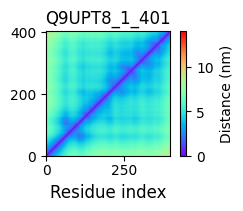

In [99]:
print('temporarily turned off colorbar for this one, watch out, vmax set to 14')
# Example usage (two separate heatmaps, different lengths OK):
M1, fig1, ax1 = avg_distance_heatmap_from_seq_name('Q9UPT8_1_401',vmax=14)
plt.savefig('figures_for_paper/Q9UPT8_1_401_distance_heatmap_no_colorbar.png',format='png',
           dpi=1000,bbox_inches='tight')



temporarily turned off ylabel for this one, watch out, vmax set to 14


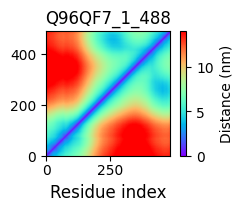

In [97]:
print('temporarily turned off ylabel for this one, watch out, vmax set to 14')
M2, fig2, ax2 = avg_distance_heatmap_from_seq_name('Q96QF7_1_488',vmax = 14)
plt.savefig('figures_for_paper/Q96QF7_1_488_distance_heatmap_no_ylabel.png',format='png',
           dpi=1000,bbox_inches='tight')

In [19]:
seq_name1 = 'Q9UPT8_1_401'
seq_name2 = 'Q96QF7_1_488'



In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.patches as patches

def plot_aa_distribution(sequence, seq_name="", figsize=(5, 2.5)):
    print('updated function for just charge distribution')
    fig, ax = plt.subplots(figsize=figsize)    
    # 4. Charge distribution (net charge per residue)
    charge_profile = []
    window_size = 5
    positions = np.arange(len(sequence))
    for i in range(len(sequence)):
        start = max(0, i - window_size//2)
        end = min(len(sequence), i + window_size//2 + 1)
        window = sequence[start:end]
        positive = sum(1 for aa in window if aa in 'KR')
        negative = sum(1 for aa in window if aa in 'DE')
        net_charge = (positive - negative) / len(window)
        charge_profile.append(net_charge)
    
    ax.plot(positions, charge_profile, color='darkred', linewidth=2, alpha=0.8)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax.fill_between(positions, charge_profile, 0, where=np.array(charge_profile) >= 0, 
                    color='red', alpha=0.3, interpolate=True)
    ax.fill_between(positions, charge_profile, 0, where=np.array(charge_profile) <= 0, 
                    color='blue', alpha=0.3, interpolate=True)
    ax.set_xlabel('Residue Position',fontsize=12)
    ax.set_ylabel('Local NCPR',fontsize=12)
    #ax.text(0.6,                 0.8,f'{seq_name}\n(window size: {window_size} residues)',
    #        transform=ax.transAxes,fontsize=11)
    ax.text(0.25,                 0.8,f'{seq_name}\n(window size: {window_size} residues)',
            transform=ax.transAxes,fontsize=11)    
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
    ax.tick_params(axis='x', which='minor', width = 0.6)
    plt.tight_layout()
    plt.close(fig)
    return fig


In [28]:
print('saving as figure as writing function')
plot_aa_distribution(idrome_prop_flucs[idrome_prop_flucs.seq_name.isin([seq_name1])]['fasta'].values[0],
                     seq_name=seq_name1).savefig('figures_for_paper/Q9UPT8_1_401_NCPR_subchain.png',format='png',dpi=1000,bbox_inches='tight')

saving as figure as writing function
updated function for just charge distribution


In [32]:
print('saving as figure as writing function, changed text position')
plot_aa_distribution(idrome_prop_flucs[idrome_prop_flucs.seq_name.isin([seq_name2])]['fasta'].values[0],
                     seq_name=seq_name2).savefig('figures_for_paper/Q96QF7_1_488_NCPR_subchain.png',format='png', dpi=1000,bbox_inches='tight')

saving as figure as writing function, changed text position
updated function for just charge distribution


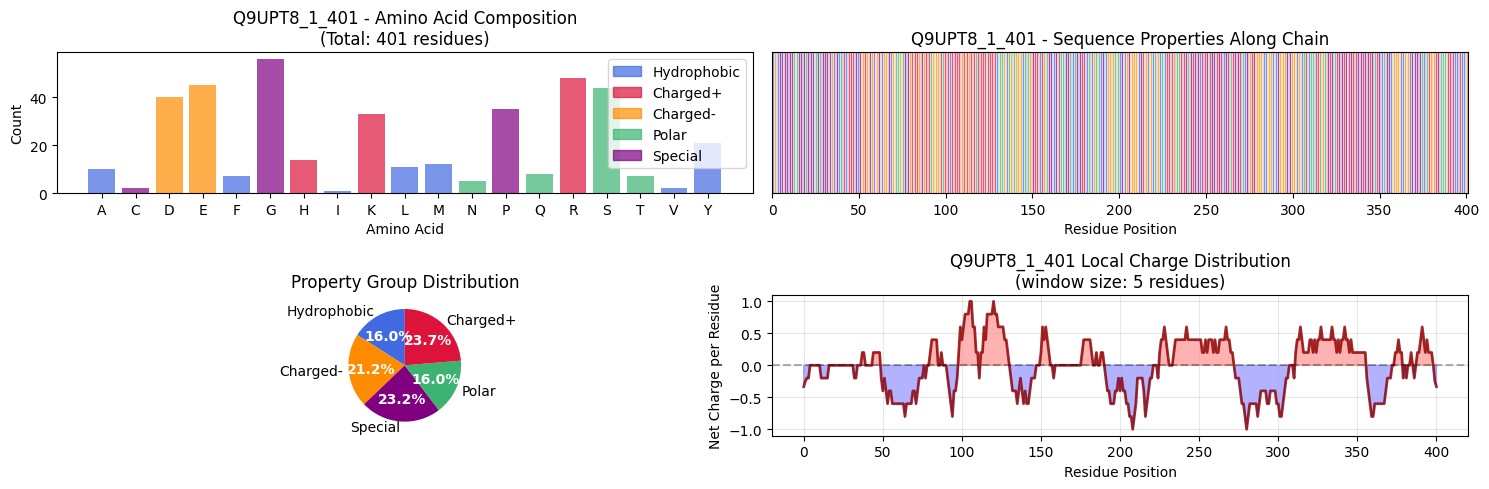

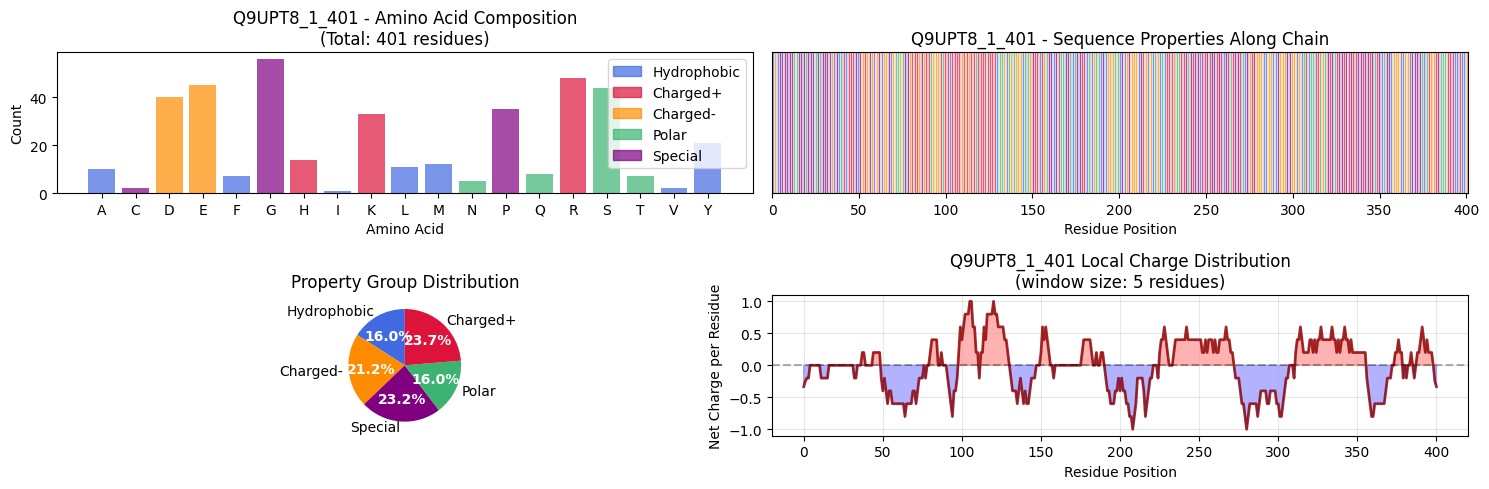

In [45]:
plot_aa_distribution(idrome_prop_flucs[idrome_prop_flucs.seq_name.isin([seq_name1])]['fasta'].values[0],
                     seq_name=seq_name1)

In [47]:
idrome_prop_flucs

AttributeError: 'DataFrame' object has no attribute 'min_mean_nu'

In [40]:
idrome_prop_flucs[idrome_prop_flucs.seq_name==seq_name2]['fasta'].values[0][150:350]

'DNSDDSEAPDDNSDDSEAPDDNSDDSEAPDDNSDDSDVPDDNSDDSSDDNSDDSSDDNSDDSDVPDDKSDDSDVPDDSSDDSDVPDDSSDDSEAPDDSSDDSEAPDDSSDDSEAPDDSSDDSEAPDDSSDDSEASDDSSDDSEASDDSSDDSEAPDDKSDDSDVPEDKSDDSDVPDDNSDDLEVPVPAEDLCNEGQIASD'

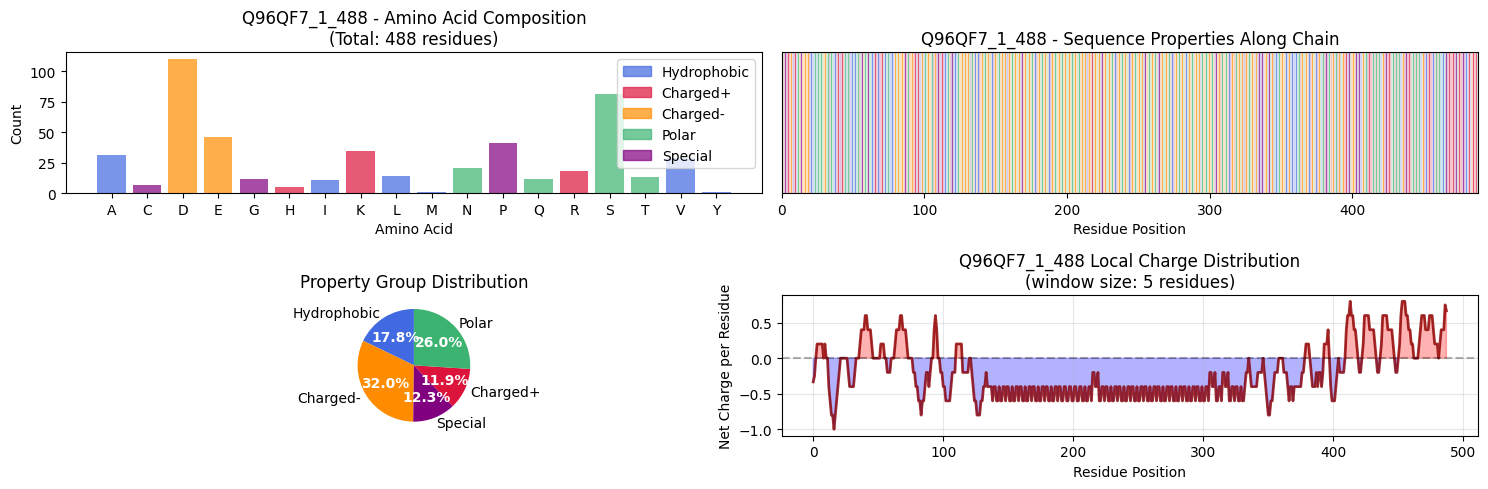

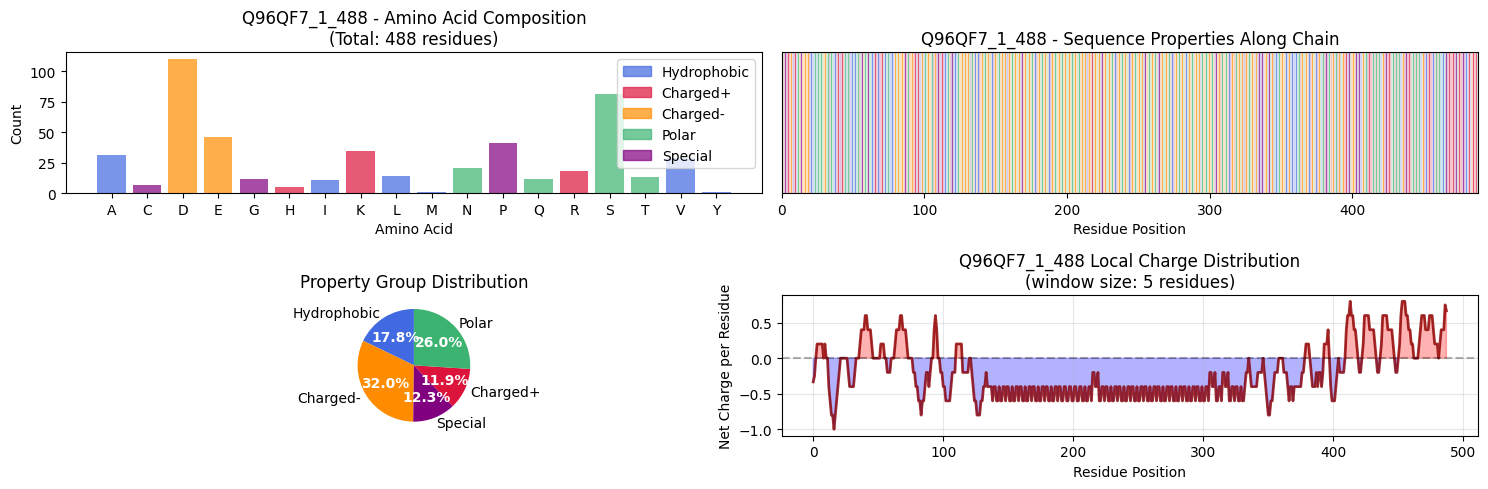

In [46]:
plot_aa_distribution(idrome_prop_flucs[idrome_prop_flucs.seq_name.isin([seq_name2])]['fasta'].values[0],
                     seq_name=seq_name2)

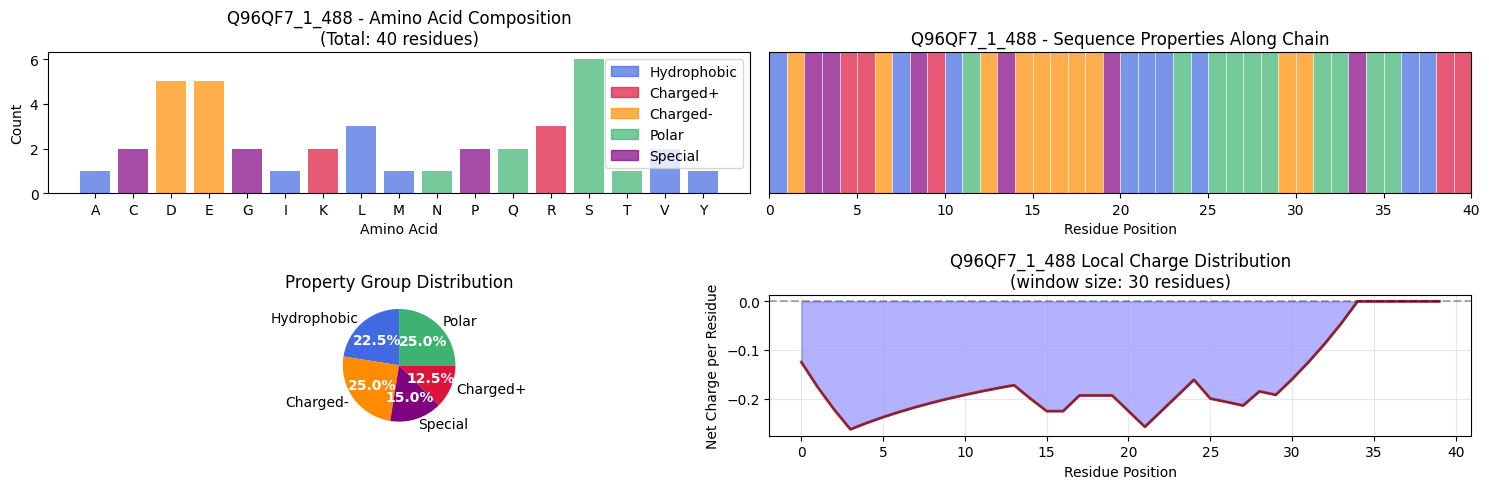

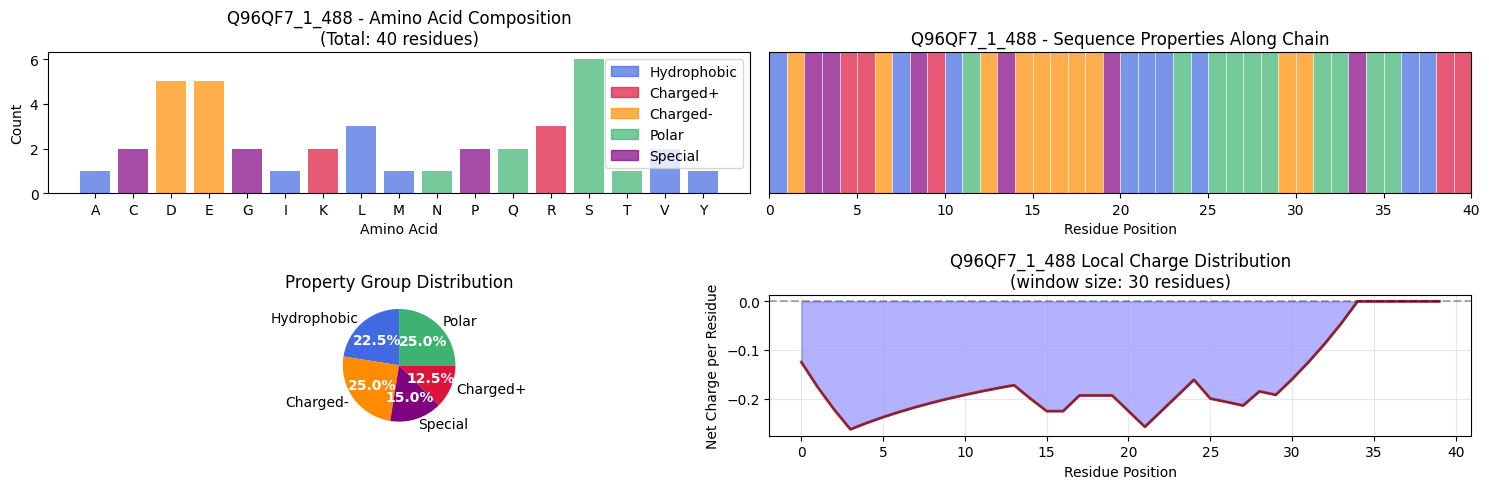

In [42]:
plot_aa_distribution(idrome_prop_flucs[idrome_prop_flucs.seq_name.isin([seq_name2])]['fasta'].values[0][0:40],
                     seq_name=seq_name2)

In [49]:
seq_name1_afrc_Ree = afrc.AnalyticalFRC(idrome_prop_flucs[idrome_prop_flucs.seq_name.isin([seq_name1])]['fasta'].values[0]).get_mean_end_to_end_distance()
seq_name2_afrc_Ree = afrc.AnalyticalFRC(idrome_prop_flucs[idrome_prop_flucs.seq_name.isin([seq_name2])]['fasta'].values[0]).get_mean_end_to_end_distance()



In [45]:
idrome_prop_flucs[idrome_prop_flucs.seq_name.isin([seq_name1])]/seq_name1_afrc.get_mean_end_to_end_distance()

26931    0.742854
Name: Rg/nm, dtype: float64

In [43]:
idrome_prop_flucs[idrome_prop_flucs.seq_name.isin([seq_name1])]['rg_rg_theta_mean']

26931    0.743601
Name: rg_rg_theta_mean, dtype: float64

In [55]:

def compute_end_to_end_distance(trajectory):
    """
    Compute end-to-end distance for each frame in trajectory
    """
    end_to_end_distances = []
    for frame in trajectory.xyz:
        # Distance between first and last residue
        distance = np.linalg.norm(frame[0] - frame[-1])
        end_to_end_distances.append(distance)
    return np.array(end_to_end_distances)

def plot_ree_comparison(seq_name1, seq_name2, seq_name1_afrc_Ree, seq_name2_afrc_Ree, stride=1):
    """
    Compute and plot normalized end-to-end distance comparisons
    
    Parameters:
    -----------
    seq_name1, seq_name2 : str
        Sequence names
    seq_name1_afrc_Ree, seq_name2_afrc_Ree : float
        Reference end-to-end distances for normalization
    stride : int
        Stride for trajectory loading
    """
    # Load trajectories
    t1 = load_trajectory(seq_name1, stride=stride)
    t2 = load_trajectory(seq_name2, stride=stride)
    
    # Compute end-to-end distances
    ree1 = compute_end_to_end_distance(t1)
    ree2 = compute_end_to_end_distance(t2)
    
    # Normalize by reference values (multiply by 10 as requested)
    ree_norm1 = (ree1 * 10) / seq_name1_afrc_Ree
    ree_norm2 = (ree2 * 10) / seq_name2_afrc_Ree
    
    # Create time arrays (in simulation steps)
    time1 = np.arange(len(ree_norm1)) * stride
    time2 = np.arange(len(ree_norm2)) * stride
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Time series comparison
    ax1.plot(time1, ree_norm1, alpha=0.7, linewidth=1, label=seq_name1, color='blue')
    ax1.plot(time2, ree_norm2, alpha=0.7, linewidth=1, label=seq_name2, color='red')
    ax1.set_xlabel('Time (simulation steps)')
    ax1.set_ylabel('Rₑₑ_norm = (Rₑₑ × 10) / Rₑₑ_afrc')
    ax1.set_title('Normalized End-to-End Distance Time Series')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add statistics to legend
    stats_text1 = f'{seq_name1}: mean={ree_norm1.mean():.3f}, std={ree_norm1.std():.3f}'
    stats_text2 = f'{seq_name2}: mean={ree_norm2.mean():.3f}, std={ree_norm2.std():.3f}'
    ax1.text(0.02, 0.98, stats_text1 + '\n' + stats_text2, 
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 2: Violin plots
    data = [ree_norm1, ree_norm2]
    labels = [seq_name1, seq_name2]
    colors = ['blue', 'red']
    
    violin_parts = ax2.violinplot(data, showmeans=True, showmedians=True)
    
    # Customize violin colors
    for i, pc in enumerate(violin_parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)
        pc.set_edgecolor('black')
    
    # Customize other elements
    violin_parts['cbars'].set_color('black')
    violin_parts['cmins'].set_color('black')
    violin_parts['cmaxes'].set_color('black')
    violin_parts['cmeans'].set_color('yellow')
    violin_parts['cmedians'].set_color('white')
    
    ax2.set_xticks([1, 2])
    ax2.set_xticklabels(labels)
    ax2.set_ylabel('Rₑₑ_norm')
    ax2.set_title('Distribution of Normalized End-to-End Distances')
    ax2.grid(True, alpha=0.3)
    
    # Add individual data points as scatter
    for i, (data_group, color) in enumerate(zip(data, colors)):
        # Add jitter to x position
        x = np.random.normal(i + 1, 0.05, size=len(data_group))
        ax2.scatter(x, data_group, alpha=0.3, color=color, s=20)
    
    plt.tight_layout()
    
    # Print some statistics
    print(f"\n--- End-to-End Distance Statistics ---")
    print(f"{seq_name1}:")
    #print(f"  Raw Rₑₑ: mean = {ree1.mean():.3f} ± {ree1.std():.3f} nm")
    print(f"  Normalized Rₑₑ: mean = {ree_norm1.mean():.3f} ± {ree_norm1.std():.3f}")
    #print(f"  Reference Rₑₑ_afrc = {seq_name1_afrc_Ree:.3f} nm")
    
    print(f"\n{seq_name2}:")
    
    print(f"  Normalized Rₑₑ: mean = {ree_norm2.mean():.3f} ± {ree_norm2.std():.3f}")
    
    
    # Compare the two distributions
    from scipy.stats import ks_2samp, mannwhitneyu
    
    ks_stat, ks_p = ks_2samp(ree_norm1, ree_norm2)
    mw_stat, mw_p = mannwhitneyu(ree_norm1, ree_norm2, alternative='two-sided')
    
    print(f"\n--- Statistical Comparison ---")
    print(f"Kolmogorov-Smirnov test: statistic = {ks_stat:.4f}, p-value = {ks_p:.4e}")
    print(f"Mann-Whitney U test: statistic = {mw_stat:.4f}, p-value = {mw_p:.4e}")
    
    # Add statistical significance to violin plot
    if mw_p < 0.05:
        significance = '*' if mw_p < 0.05 else ''
        significance += '*' if mw_p < 0.01 else ''
        significance += '*' if mw_p < 0.001 else ''
        y_max = max(ree_norm1.max(), ree_norm2.max())
        ax2.plot([1, 2], [y_max * 1.05, y_max * 1.05], 'k-', lw=1.5)
        ax2.text(1.5, y_max * 1.07, significance, ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    return fig




--- End-to-End Distance Statistics ---
Q9UPT8_1_401:
  Normalized Rₑₑ: mean = 0.767 ± 0.288

Q96QF7_1_488:
  Normalized Rₑₑ: mean = 1.048 ± 0.431

--- Statistical Comparison ---
Kolmogorov-Smirnov test: statistic = 0.3110, p-value = 4.1015e-43
Mann-Whitney U test: statistic = 304400.0000, p-value = 7.8961e-52


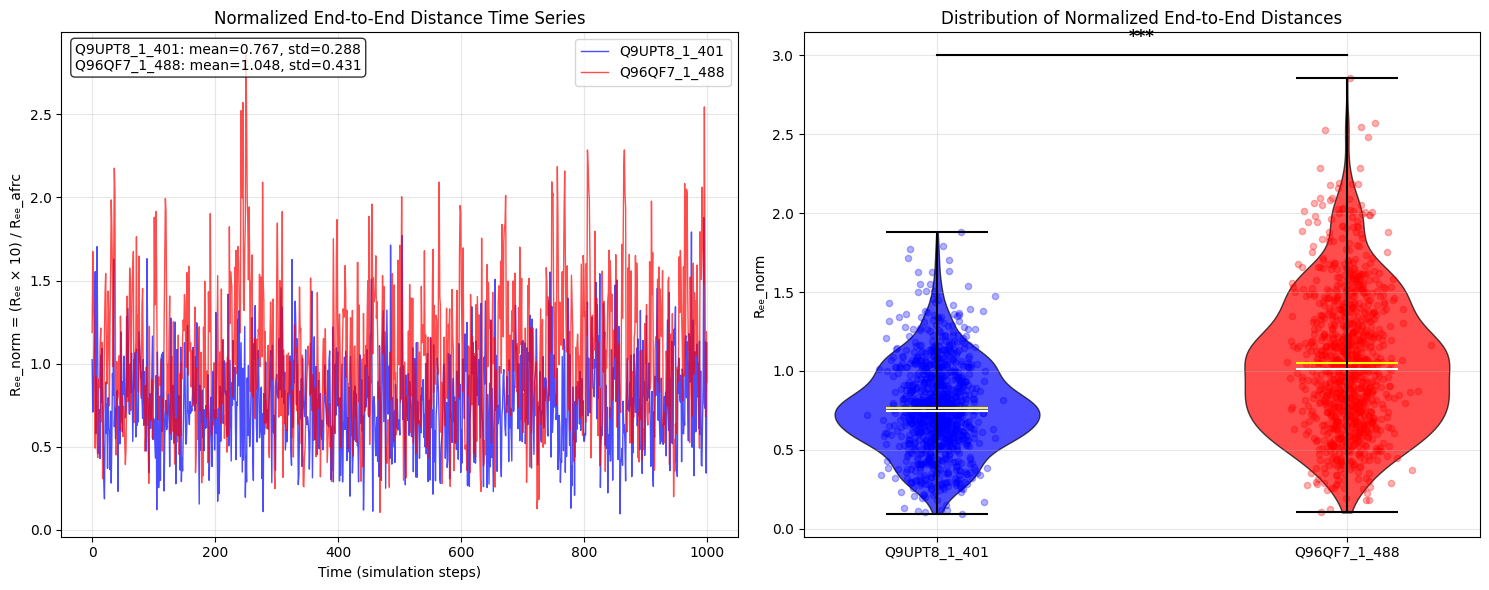

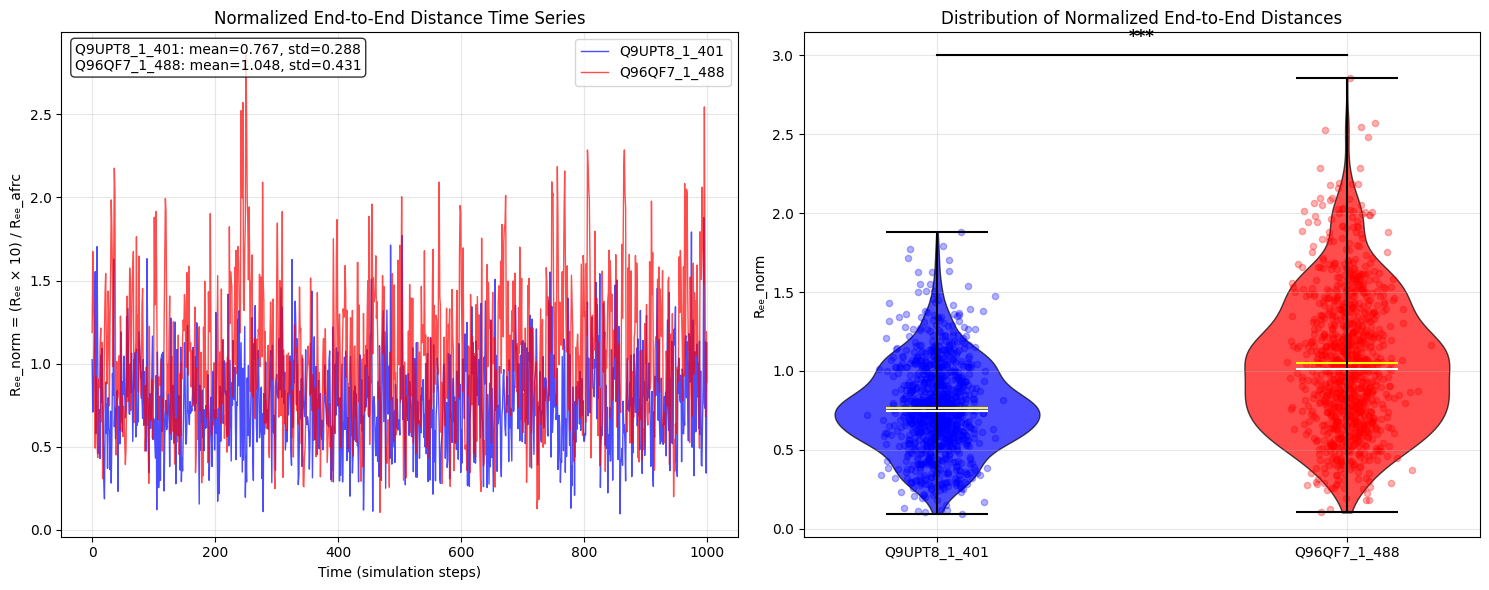

In [56]:
plot_ree_comparison(seq_name1, seq_name2, seq_name1_afrc_Ree, seq_name2_afrc_Ree, stride=1)

In [64]:

def compute_rsa_rs_violin_plots(seq_name1, seq_name2):
    """
    Generate violin plots of RSA and Rs distributions for two IDRs
    """
    # Compute RSA and Rs for both sequences
    def compute_rsa_rs(seq_name):
        example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
        t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')[10:]
        t_df_moments = pd.DataFrame(md.principal_moments(t), columns=['R3','R2','R1']).copy()
        t_df_moments['asphericity'] = t_df_moments.R1.values - (0.5*(t_df_moments.R2.values + t_df_moments.R3.values))
        t_df_moments['acylindricity'] = t_df_moments.R2.values - t_df_moments.R3.values
        t_df_moments['RSA'] = (t_df_moments.asphericity.values**2 + (0.75*t_df_moments.acylindricity.values**2)) / (t_df_moments.R1.values + t_df_moments.R2.values + t_df_moments.R3.values)**2
        
        protein_df = t_df_moments[['RSA']].copy()
        del t_df_moments
        
        protein_df['Rg2'] = md.compute_rg(t)**2
        first_atom_index = t.topology.select(f"residue {0}")[0]
        last_atom_index  = t.topology.select(f"residue {t.topology.n_residues - 1}")[0]
        ree_series_nm = md.compute_distances(t,atom_pairs= [[first_atom_index, last_atom_index]]).flatten()
        
        protein_df['Ree2'] = ree_series_nm**2
        protein_df['Rs'] = protein_df['Ree2'] / protein_df['Rg2']
        
        return protein_df[['RSA', 'Rs']]
    
    # Get data for both sequences
    data1 = compute_rsa_rs(seq_name1)
    data2 = compute_rsa_rs(seq_name2)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: RSA distributions
    rsa_data = [data1['RSA'].values, data2['RSA'].values]
    violin_parts1 = ax1.violinplot(rsa_data, showmeans=True, showmedians=True)
    
    # Customize RSA violin plot
    for i, pc in enumerate(violin_parts1['bodies']):
        pc.set_facecolor(['blue', 'red'][i])
        pc.set_alpha(0.7)
        pc.set_edgecolor('black')
    
    violin_parts1['cbars'].set_color('black')
    violin_parts1['cmins'].set_color('black')
    violin_parts1['cmaxes'].set_color('black')
    violin_parts1['cmeans'].set_color('yellow')
    violin_parts1['cmedians'].set_color('white')
    
    ax1.set_xticks([1, 2])
    ax1.set_xticklabels([seq_name1, seq_name2])
    ax1.set_ylabel('RSA')
    ax1.set_title('RSA Distributions')
    ax1.grid(True, alpha=0.3)
    
    # Add individual data points for RSA
    for i, (data_group, color) in enumerate(zip(rsa_data, ['blue', 'red'])):
        x = np.random.normal(i + 1, 0.05, size=len(data_group))
        ax1.scatter(x, data_group, alpha=0.3, color=color, s=20)
    
    # Plot 2: Rs distributions
    rs_data = [data1['Rs'].values, data2['Rs'].values]
    violin_parts2 = ax2.violinplot(rs_data, showmeans=True, showmedians=True)
    
    # Customize Rs violin plot
    for i, pc in enumerate(violin_parts2['bodies']):
        pc.set_facecolor(['blue', 'red'][i])
        pc.set_alpha(0.7)
        pc.set_edgecolor('black')
    
    violin_parts2['cbars'].set_color('black')
    violin_parts2['cmins'].set_color('black')
    violin_parts2['cmaxes'].set_color('black')
    violin_parts2['cmeans'].set_color('yellow')
    violin_parts2['cmedians'].set_color('white')
    
    ax2.set_xticks([1, 2])
    ax2.set_xticklabels([seq_name1, seq_name2])
    ax2.set_ylabel('$R_s$')
    ax2.set_title('$R_s$')
    ax2.grid(True, alpha=0.3)
    
    # Add individual data points for Rs
    for i, (data_group, color) in enumerate(zip(rs_data, ['blue', 'red'])):
        x = np.random.normal(i + 1, 0.05, size=len(data_group))
        ax2.scatter(x, data_group, alpha=0.3, color=color, s=20)
    
    plt.tight_layout()
    return fig

# Usage:
# fig = compute_rsa_rs_violin_plots('seq_name1', 'seq_name2')
# plt.show()

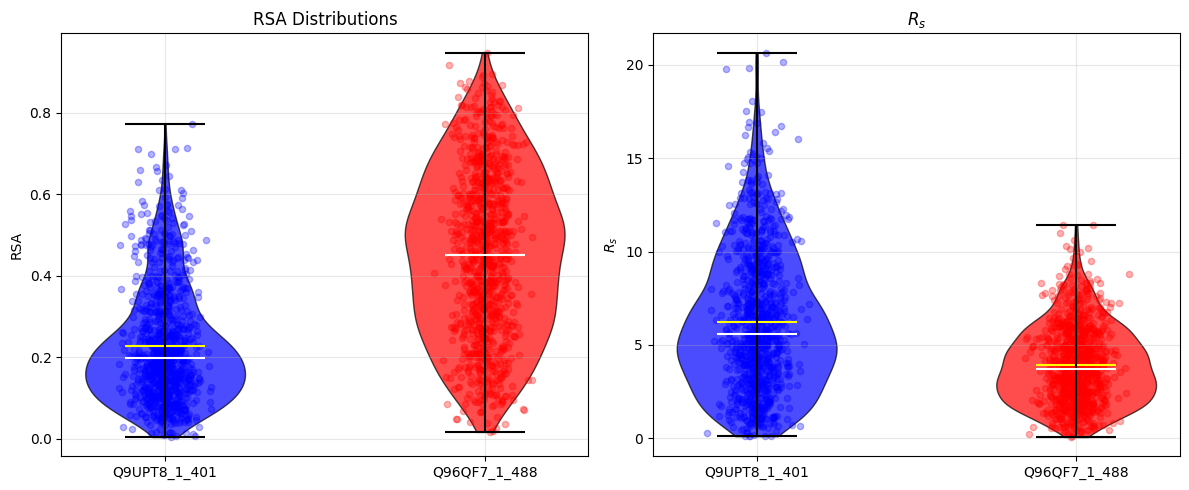

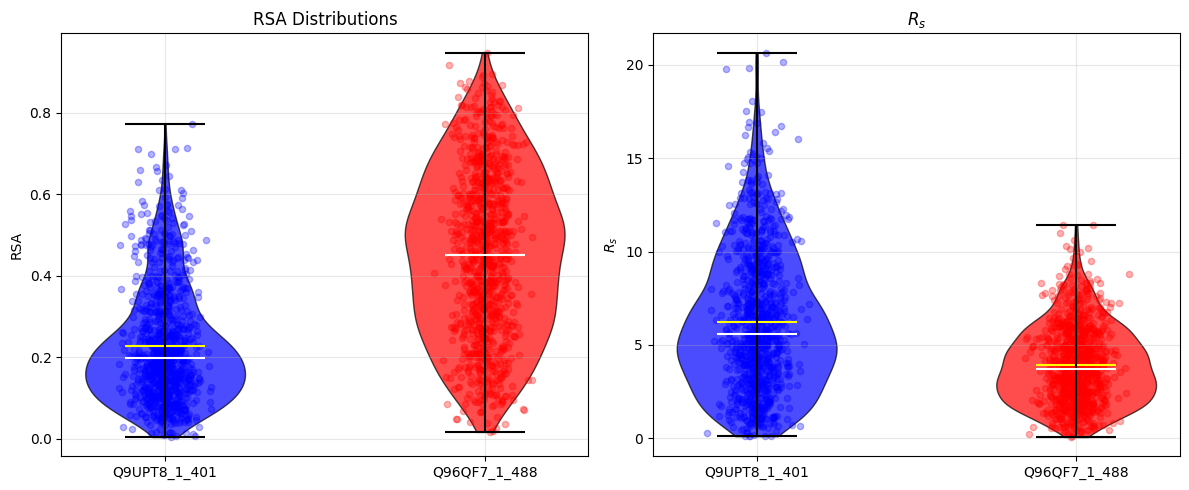

In [65]:
compute_rsa_rs_violin_plots(seq_name1, seq_name2)